In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import math
pd.set_option("display.max_rows", None)
np.random.seed(seed=1903)

In [2]:
def numrelu(x, breaks):
    centers = np.linspace(0, 1, breaks).tolist()
    return np.vstack([[1]*x.shape[0], np.array([(x-c)*(x>c) for c in centers])]).T

In [3]:
def numpoly(x, degree):
    # TODO: Fix. There is no need to add a column of ones because the first colun of x**0 is a column of ones.
    return np.vstack([[1]*x.shape[0], np.array([t**c for c in range(degree)])]).T

In [4]:
def numstep(x, breaks):
    centers = np.linspace(0, 1, breaks).tolist()
    # TODO: Fix. There is no need to have a column of ones in the beginning for this basis, let alone two.
    return np.vstack([[1]*x.shape[0], [1]*x.shape[0], np.array([np.piecewise(x, [(x >= centers[i]) & (x <= centers[i+1])], [1., 0.]) for i in range(breaks-1)])]).T

In [5]:
def numbsplines(x, centers):
    # TODO: Implement
    pass

In [6]:
def reconstruct_function(x, w_x):
    return np.sum((x * w_x).T, axis=0)

In [7]:
def gen_random_design(dims, a=-1, b=1):
    experiments = dims[0]
    features = dims[1]
    df = pd.DataFrame((b - a)*np.random.random((experiments, features)) + a) # random uniform [-1,1]
    df.columns = ['w' + str(x) for x in list(range(features))]
    return df

In [8]:
def gen_model_matrix(data, J_mat):
    J_cgb = data @ J_mat
    Z_mat = np.append(np.array([1]*J_cgb.shape[0]).reshape((-1,1)), J_cgb, axis=1)
    return Z_mat

In [13]:
t_detail = 100
w_detail = 5

n_exp = 12
x_breaks = 5
b_brakes = 10

t = np.linspace(0, 1, t_detail)
dt = t[1] - t[0]

w_levels = {}
for i in range(x_breaks + 1):
    w_levels[i] = np.linspace(-1, 1, w_detail).tolist()

# Define basis and centers
# c_t = numrelu(x=t, breaks=x_breaks)
# c_t = numpoly(x=t, degree=x_breaks)
c_t = numstep(x=t, breaks=x_breaks)
c_bas = 'numstep'
b_t = numrelu(x=t, breaks=b_brakes)
J_cb = np.cumsum((c_t.T @ b_t)/t_detail, axis=1) * dt # Calculate Integral of basis matrix
J_cb.shape

(6, 11)

In [14]:
hstry_opt_cr = []
hstry_designs = np.array([]).reshape((0, x_breaks + 1))
design_matrix = gen_random_design((n_exp, x_breaks + 1)) # Start with random design matrix

for exp in tqdm(range(n_exp)):
    for weight in range(x_breaks+1):
        coordinate_opt_cr = []
        for _, level in enumerate(w_levels[weight]):
            design_matrix.iat[exp, weight] = level
            model_matrix = gen_model_matrix(data=design_matrix, J_mat=J_cb)
            # Calculate Criterion
            engine = np.linalg.det(model_matrix.T @ model_matrix)
            coordinate_opt_cr.append(engine)

        hstry_opt_cr.append([exp, weight, *coordinate_opt_cr])
        # Change W matrix in order to maximize d_opt_criterion
        design_matrix.iat[exp, weight] = w_levels[weight][coordinate_opt_cr.index(max(coordinate_opt_cr))]
design_matrix

100%|██████████| 12/12 [00:00<00:00, 216.24it/s]


,w0,w1,w2,w3,w4,w5
0,1.0,1.0,0.5,1.0,0.0,0.5
1,1.0,0.0,1.0,-1.0,0.5,0.0
2,0.0,0.5,-1.0,-1.0,-1.0,1.0
3,0.0,-1.0,0.5,0.0,0.5,0.5
4,0.5,-0.5,-0.5,-1.0,-1.0,1.0
5,-1.0,-1.0,1.0,0.0,0.5,0.5
6,-1.0,0.0,-0.5,0.0,0.0,-0.5
7,0.5,1.0,-0.5,-1.0,0.5,1.0
8,0.5,-1.0,1.0,1.0,-1.0,-1.0
9,0.0,-1.0,-1.0,-0.5,-1.0,1.0


In [15]:
if c_bas == 'numrelu':
    for _ in range(1, x_breaks + 1):
        design_matrix[f'w{_}_scaled'] = 2 / (x_breaks + 1) * (design_matrix[f'w{_}'] - design_matrix['w0'])
    design_matrix_scaled = design_matrix[['w0', *[f'w{i}_scaled' for i in range(1, x_breaks + 1)]]]
elif c_bas in ['numpoly', 'numstep']:
    design_matrix_scaled = design_matrix[['w0', *[f'w{i}' for i in range(1, x_breaks + 1)]]]

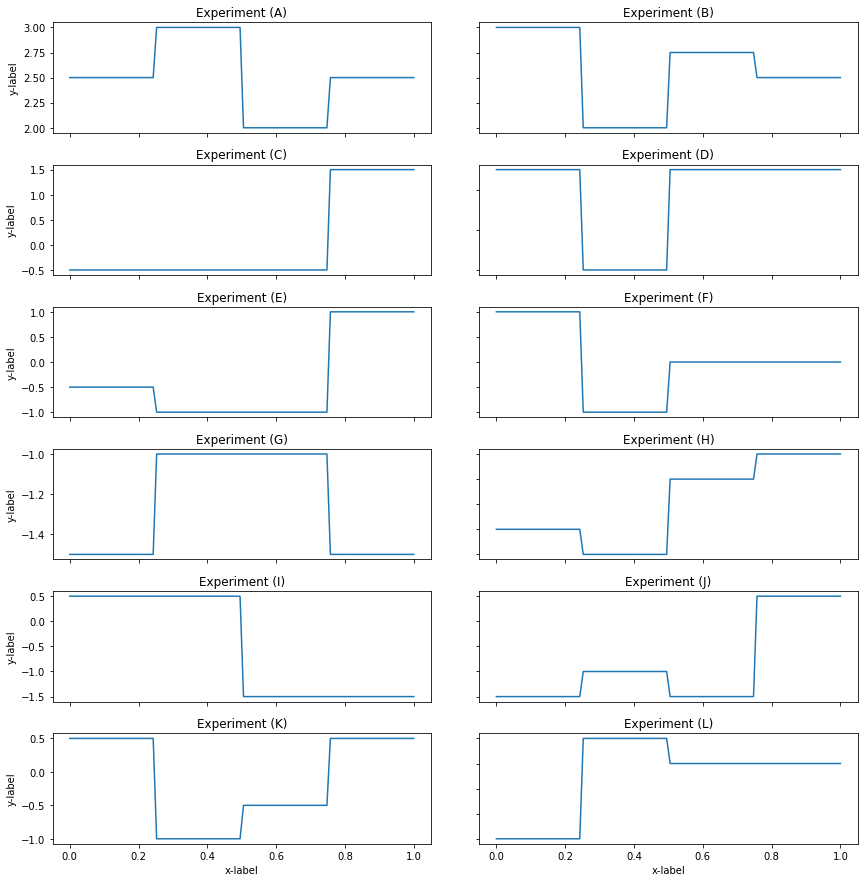

In [16]:
rows = math.ceil(n_exp/2)
cols = 2
fig, axs = plt.subplots(rows,cols, figsize=(12,12))
fig.tight_layout()
n=0
for i in range(rows):
    for j in range(cols):
        try:
            axs[i, j].plot(t, reconstruct_function(c_t, np.array(design_matrix_scaled.iloc[n, :]).reshape((-1,1)).T))
            axs[i, j].set_title(f'Experiment ({chr(65 + n)})')
            n += 1
        except:
            pass

for ax in axs.flat:
    ax.set_xlabel('x-label')
    ax.set_ylabel('y-label')
    if c_bas == 'numrelu':
        ax.set_xlim([-0.05, 1.05])
        ax.set_ylim([-1.2, 1.2])

for ax in axs.flat:
    ax.label_outer()